In [74]:
import tomotopy as tp
import pandas as pd
import pickle
import numpy as np
import sys
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re

# Topics embeddings pipeline 
Here we implement the embedding pipeline for the topics extracted by the collection. <br>
The results will be the following: 
1. Topic embeddings 
2. Document embeddings 
3. Other nodes embeddings? 

## 1. Loading topic model(s) and collection

In [75]:
collection = pickle.load(open( "collection_cleaned_fullwords.p", "rb" ))

In [76]:
num_batches = 4
batches = np.array_split(collection, num_batches)

In [77]:
def get_batch_indices(batches):
    res = []
    for i,batch in enumerate(batches):
        res += [i]*len(batch)
    return res
batch_indices = get_batch_indices(batches)

In [78]:
# number of docs per batch
for b in batches: print(len(b))

5124
5124
5123
5123


Batch training models 

In [79]:
num_topics_per_batch = 125
models = []
model_names = ['LDA1batch1.bin','LDA1batch2.bin','LDA1batch3.bin','LDA1batch4.bin']
for name in model_names:
    models.append(tp.LDAModel.load(name))

## 2. Extract the topics 

In [80]:
def get_top_topics(document, model, min_score=0.8):
    """ 
    Extracting top n topics for each document. 
    Selects the n most likely topics whose p(topic|document) sum to min_score.
    """
    # inserting the document in the model
    new_doc = model.make_doc(document)
    _,_ = model.infer(new_doc)
    # ordering from most probable topic to least one 
    dist = new_doc.get_topic_dist()
    indices = np.flip(np.argsort(dist))
    score = 0
    indices_kept = []
    probs_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        indices_kept.append(index)
        probs_kept.append(dist[index])
    return list(zip(indices_kept, probs_kept))

In [81]:
# extracting topics for the original collection
coll2topics = []
# this takes a super long time
for model, batch in zip(models,batches):
    coll2topics += [get_top_topics(doc, model) for doc in batch]

In [82]:
len(coll2topics)

20494

In [83]:
def get_top_words(topic, model, min_score=0.8):
    """
    Extracting top n words for each document. 
    Selects the n most likely words whose p(word|topic) sum to min_score.
    """
    dist = model.get_topic_word_dist(topic)
    indices = np.flip(np.argsort(dist))
    score = 0
    word_kept = []
    word_prob_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        word_kept.append(model.used_vocabs[index])
        word_prob_kept.append(dist[index])
    return list(zip(word_kept, word_prob_kept))

In [84]:
topics2words = []
topics2words_batched = [] # saving both topics and their batches 
for model in models: 
    # extracting only top 25% of the words
    twt = [get_top_words(i, model, min_score=0.5) for i in range(num_topics_per_batch)]
    topics2words += twt
    topics2words_batched += [twt]

In [85]:
len(topics2words)

500

In [86]:
len(topics2words_batched)

4

## 3. Embedding words in topics

We will use Glove Embeddings to embed the words in the topics. 

In [87]:
import pickle 
import numpy as np 
import os 
import time
import torch

In [89]:
# Loading from binary the glove vocabulary and embedding 
glove_vocab_path = "glove_vocab"
glove_embedding_path = "glove_embedding"
with open(glove_vocab_path, "rb") as fp:  
    glove_vocab = pickle.load(fp)
with open(glove_embedding_path, "rb") as fp: 
    glove_embedding = pickle.load(fp)
assert len(glove_vocab)==len(glove_embedding)

In [92]:
def get_list_embeddings_topic(topic, vocab, embedding, silence=False):
    """ Topic is represented as a list of tuples (word, word weight)"""
    matched = 0 
    total = 0
    topic_embeddings = []
    topic_weights = []
    
    start = time.time()
    
    for item in topic: 
        word, weight = item
        total+=1
        #check if the word appears in vocabulary 
        if word in vocab.values(): 
            matched+=1
            emb = embedding[list(vocab.values()).index(word)]
            topic_embeddings += [emb]
            topic_weights += [weight]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
        print("Proportion of matched words: "+str(round(matched/total,2)))
    return topic_embeddings, topic_weights

In [93]:
topic_embeddings, topic_weights = get_list_embeddings_topic(topics2words[0], glove_vocab, glove_embedding)

Total time: 0.96 s.
Proportion of matched words: 0.91


# Embedding nodes - baseline

## 4. Embedding topics 

In [94]:
def get_convex_combination(weights, embeddings):
    """ Obtain an embedding as convex combination of embedding vectors according 
    to the weights provided."""
    weight_vec = np.asarray(weights)
    emb_vec = np.asarray(embeddings)
    normalized_weights = weight_vec / np.sum(np.absolute(weight_vec))
    return normalized_weights.transpose().dot(emb_vec)

In [95]:
topic_emb = get_convex_combination(topic_weights, topic_embeddings)

In [96]:
def get_convex_topics_embeddings(topics_collection, vocab, embedding):
    """ Runs the above function over a whole collection of topics"""
    topics_embs = []
    for topic2word in topics_collection:
        # extract the emebddings for the words in the topic 
        topic_embeddings, topic_weights = get_list_embeddings_topic(topic2word, vocab, embedding, silence=True)
        # combine the embeddings with a convex sum 
        topic_emb = get_convex_combination(topic_weights, topic_embeddings)
        topics_embs += [topic_emb]
    return topics_embs

In [97]:
# TODO: look at topic embeddings across batches and measure their similarity

In [98]:
# these two also take a while
topics_embs = get_convex_topics_embeddings(topics2words, glove_vocab, glove_embedding)

In [99]:
topics_embs_batched = [get_convex_topics_embeddings(t2w, glove_vocab, glove_embedding) for t2w in topics2words_batched]

Now let's have a look at the results!

In [100]:
def nearest_neighbors(this, others):
    """Returns the most similar vectors among others to the given one """
    cos = torch.nn.CosineSimilarity(dim = -1)
    ranks = cos(torch.tensor(this), torch.tensor(others))
    mostSimilar = []
    return ranks.numpy().argsort()[::-1] 

In [101]:
# let's look at the first topic 
nns_100 = nearest_neighbors(topics_embs[100], topics_embs)

In [102]:
def visualise_most_similar_topics(topic_id, batch_id, topics_embs, topics2words,
                                  topics_embs_batched, topics2words_batched, n=10):
    """Prints the words of the topic and its neareast neighbors."""
    nns = nearest_neighbors(topics_embs_batched[batch_id][topic_id], topics_embs)
    print("-"*10)
    print("Topic "+ str(topic_id))
    print(" ".join(item[0] for item in topics2words_batched[batch_id][topic_id]))
    print("-"*10)
    print(str(n)+" most similar topics")
    for i in range(n):
        print("Topic "+str(nns[i+1]))
        print(" ".join(item[0] for item in topics2words[nns[i+1]]))

In [103]:
visualise_most_similar_topics(35, 1, topics_embs, topics2words,topics_embs_batched, topics2words_batched, n=3)

----------
Topic 35
pm soils quartz fr pretreatment soil floodplain pre grid graphite confinement steam lean environment invertebrate transform hillslope anthropogenic ng river freshly ftir caco algal hydrological saplings hydrologic like solid activity tsc hrms termination studied decreased periods rewetting pg inventory plagioclase al areas gc airborne
----------
3 most similar topics
Topic 89
soil drought plant biomass organic microbial fluxes ecosystem nutrient co site extreme climatic increased si uptake grassland stable carsharing rates basin sediments highest year gamma responses term feeding balance seasonal ago terrestrial reduced
Topic 426
soil crisis plants soils restoration biomass communities growth grassland agriculture us wealth release norms mo species ph loss nutrient terrestrial shifting mild actors rossi role terrorism could diverse cultivar inoculation experiences third restriction linked engagement products differentiated
Topic 277
sediment sediments water sediment

## 5. Documents embeddings

In [104]:
abstracts_data = pd.read_csv("abstracts_eng.csv")

In [105]:
# checking the ordering by visual inspection 
n = np.random.randint(len(collection))
print(abstracts_data["abstract"][n][0:500]) 
print("")
print(" ".join(collection[n][0:50]))

Understanding the principles that govern the assembly of microbial communities across earth’s biomes is a major challenge in modern microbial ecology. This pursuit is complicated by the difficulties of mapping functional roles and interactions onto communities with immense taxonomic diversity and of identifying the scale at which microbes interact [1]. To address this challenge, here, we focused on the bacterial communities that colonize and degrade particulate organic matter in the ocean [2, 3,

understanding principles govern assembly microbial communities across earth biomes major challenge modern microbial ecology pursuit complicated difficulties mapping functional roles interactions onto communities immense taxonomic diversity identifying scale microbes interact address challenge focused bacterial communities colonize degrade particulate organic matter ocean show assembly communities simplified linear combination functional modules using


In [106]:
enriched = abstracts_data
enriched["topics"] = coll2topics
enriched["batchID"] = batch_indices
#enriched=enriched.explode("topics")
enriched.head(5)

,abstract,id,title,topics,batchID
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"[(60, 0.24186938), (51, 0.10589432), (79, 0.07...",0
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz,"[(5, 0.20627172), (40, 0.16780958), (29, 0.108...",0
2,China’s growing influence in Europe has the po...,346708.0,China as a Stress Test for Europe’s Coherence,"[(0, 0.14767313), (14, 0.1092189), (25, 0.0920...",0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0,"On the Belt, on the Road: China’s Pivot to Eur...","[(57, 0.16084893), (0, 0.14146255), (16, 0.098...",0
4,Passenger transit modes typical of the urban s...,187461.0,Applications and Future Developments: Modellin...,"[(14, 0.11849773), (16, 0.07719317), (2, 0.072...",0


In [107]:
docs2topics = enriched[["topics","batchID"]].values.tolist()

In [108]:
def get_list_embeddings_document(doc, topics_embedding, silence=False):
    """ Returns the list of topic embeddings and topic weights for the given document.
    The document is represented as the tuple ([(topic_id, topic_weight)], batch_id)"""
    doc_embeddings = []
    doc_weights = []
    
    start = time.time()
    
    topics, batch_id = doc
    
    for topic in topics: 
        topic_id, weight = topic
        emb = topics_embedding[batch_id][topic_id]
        doc_embeddings += [emb]
        doc_weights += [weight]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
    return doc_embeddings, doc_weights

In [109]:
doc0_embs = get_list_embeddings_document(docs2topics[0], topics_embs_batched)
len(doc0_embs[0])

Total time: 0.0 s.


10

In [110]:
# finally documents embeddings 
def get_convex_docs_embeddings(documents_collection, topics_embedding):
    """ Runs the above function over a whole collection of documents"""
    docs_embs = []
    for doc2topics in documents_collection:
        # extract the emebddings for the words in the topic 
        doc_embeddings, doc_weights = get_list_embeddings_document(doc2topics, topics_embedding, silence=True)
        # combine the embeddings with a convex sum 
        doc_emb = get_convex_combination(doc_embeddings, doc_weights)
        docs_embs += [doc_emb]
    return docs_embs

In [111]:
documents_embeddings = get_convex_docs_embeddings(docs2topics, topics_embs_batched)

In [112]:
def visualise_most_similar_docs(doc_id, docs_embeddings, docs_collection, n=10):
    """Prints the words of the topic and its neareast neighbors."""
    nns = nearest_neighbors(docs_embeddings[doc_id], docs_embeddings)
    print("Document "+ str(doc_id))
    print((docs_collection[doc_id]).partition("||")[0])
    print("-"*10)
    print(str(n)+" most similar documents in the collection")
    for i in range(n):
        print("")
        print("Document "+str(nns[i+1]))
        print((docs_collection[nns[i+1]]).partition("||")[0])

In [113]:
visualise_most_similar_docs(32, documents_embeddings, abstracts_data["abstract"], n=3)

Document 32
This chapter by Alex Bolfrass contrasts the responses of the Obama and Trump administrations to Syria’s use of chemical weapons. Both administrations pursued the same stated aim: to cause the Assad regime to refrain from using chemical munitions in fighting its civil war without the US becoming a combatant. Neither administration achieved this aim in full. Nonetheless, the combined effect of their approaches was a creditable reduction in the chemical munitions available to the Syrian government’s forces and a potentially lasting reduction of their use.
----------
3 most similar documents in the collection

Document 31
The relevance of nuclear weapons in world affairs is increasing, not decreasing. All nuclear powers modernize their arsenals. This may result in destabilizing effects on nuclear deterrence constellations. At the same time, the discrepancy between the importance of arms control as a necessary supplement to nuclear deterrence on the one hand and its actual, limi

## 6. Authors embeddings

In [127]:
# loading the graph data 
graph_data = pd.read_csv("graph_data_final.csv")

In [128]:
graph_data = pd.merge(abstracts_data.reset_index(level=0, inplace=False)[["index","title"]], #adding column index, dropping everything else
                      graph_data, on=["title"], how="inner")
graph_data.head(1)

,index,title,id,author,publication_date,publication_type,abstract,language,journal,organisation_unit_code,organisation,department
0,0,Asymptotic versions for operators and operator...,188444.0,"Milman, Vitali",1999.0,Book Chapter,The goal of this note is to introduce new clas...,en,Mathematical Sciences Research Institute Publi...,NaN,NaN,NaN


We will first use the metadata data to compute a scoring author-publication that we will then use to combine the publications embeddings 

In [129]:
counts_df = graph_data.groupby(["author"]).size().reset_index(name='counts')
graph_data_prime = pd.merge(counts_df, graph_data, on=["author"], how="inner")
graph_data_prime = graph_data_prime[["index","counts","title","author","publication_date","publication_type"]]
graph_data_prime.head(2)

,index,counts,title,author,publication_date,publication_type
0,14835,1,A Follow-Up of the Multicenter Collaborative S...,454 HIV-1 Alpha Study Group,2016.0,Journal Article
1,8399,1,Dysfunctional Autism Risk Genes Cause Circuit-...,"A-Bhaskaran, Arjun",2018.0,Journal Article


In [130]:
counts_df2 = graph_data_temp.groupby(["title"]).size().reset_index(name ='number_of_authors')
graph_data_prime = pd.merge(counts_df2, graph_data_prime, on=["title"], how="inner")
graph_data_prime = graph_data_prime[["index","counts","title","author","publication_date","publication_type","number_of_authors"]]
graph_data_prime.head(2)

,index,counts,title,author,publication_date,publication_type,number_of_authors
0,13030,33,"""Canopy Catalysts"" for Alkyne Metathesis: Moly...","Copéret, Christophe",2020.0,Journal Article,8
1,13030,1,"""Canopy Catalysts"" for Alkyne Metathesis: Moly...","Fürstner, Alois",2020.0,Journal Article,8


In [134]:
def alpha(x, t=20): 
    """ Hard thresholding function for number of publications"""
    if x>t: return t
    return x

# totally arbitrary- can be changed
publication_types_scores = {
    "Conference Paper":10,
    "Journal Article":9,
    "Book Chapter":8,
    "Review Article":7}

In [121]:
def score_publication(date, pub_type, number_of_authors, gamma = 0.5):
    """ Scoring function for author-publication pair"""
    #todo/future-work: add "is_professor" qualifier to the scoring 
    date_weight = np.exp(date - (avg_date))
    author_weight = (1/number_of_authors)**gamma
    pub_type_weight = publication_types_scores.get(pub_type,1)
    return pub_type_weight*date_weight*author_weight

In [131]:
graph_data_prime["score"] = graph_data_prime.apply(lambda row: score_publication(row["publication_date"], row["publication_type"], row["number_of_authors"]), axis=1)

In [136]:
max_date = max(graph_data_prime["publication_date"])
min_date = min(graph_data_prime["publication_date"])
avg_date = np.mean(graph_data_prime["publication_date"])
avg_date

2016.0885307318053

In [138]:
print(graph_data_prime.shape)
graph_data_prime = graph_data_prime.drop_duplicates(["title","author"])
print(graph_data_prime.shape)

(159123, 8)
(159123, 8)


In [139]:
graph_data_prime.head(2)

,index,counts,title,author,publication_date,publication_type,number_of_authors,score
0,13030,33,"""Canopy Catalysts"" for Alkyne Metathesis: Moly...","Copéret, Christophe",2020.0,Journal Article,8,159.010951
1,13030,1,"""Canopy Catalysts"" for Alkyne Metathesis: Moly...","Fürstner, Alois",2020.0,Journal Article,8,159.010951


In [140]:
graph_data_prime["pub"]=list(zip(graph_data_prime["index"], graph_data_prime["score"]))
graph_data_prime = graph_data_prime.groupby(["author"])["pub"].apply(list).reset_index(name='pubs')

In [141]:
authors2pubs = graph_data_prime.values.tolist()

In [142]:
np.mean([len(l[1]) for l in authors2pubs]) # average number of publications per author

2.3179891328098825

In [143]:
# define a threshold function to only take t publications with highest score into account for author embedding
def trim_by_threshold(embeddings, weights, t = 20):
    if len(embeddings) <= t:
        return embeddings, weights
    else:
        ordered_by_weight = sorted(zip(weights, embeddings), key=lambda pair: pair[0], reverse = True)
        ordered_weights = [weight for weight,_ in ordered_by_weight]
        ordered_embeddings = [embeddings for _,embeddings in ordered_by_weight]
        return ordered_embeddings[:t], ordered_weights[:t]

In [144]:
def get_list_embeddings_author(author, documents_embeddings, silence=False):
    """ Returns the list of document embeddings and document weights for the given author.
    The author is represented as the list [(pub, score)]"""
    auth_embeddings = []
    auth_weights = []
    
    start = time.time()
    
    
    for item in author[1]: 
        pub_id, weight = item
        emb = documents_embeddings[pub_id-1]
        auth_embeddings += [emb]
        auth_weights += [weight]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
    return auth_embeddings, auth_weights

In [145]:
# finally documents embeddings 
def get_convex_auth_embeddings(authors2pubs, documents_embeddings):
    """ Runs the above function over a whole collection of documents"""
    auths_embs = []
    for author in authors2pubs:
        # extract the emebddings for the words in the topic 
        auth_embeddings, auth_weights = get_list_embeddings_author(author, documents_embeddings, silence=True)
        # combine the embeddings with a convex sum 
        # threshold to the most important publications
        auth_embeddings_thres, auth_weights_thres = trim_by_threshold(auth_embeddings, auth_weights, t = 20)
        auth_emb = get_convex_combination(auth_embeddings_thres, auth_weights_thres)
        auths_embs += [auth_emb]
    return auths_embs

In [146]:
authors_embeddings = get_convex_auth_embeddings(authors2pubs, documents_embeddings)

In [170]:
def visualise_most_similar_authors(author_id, authors_embeddings, authors2pubs,  n=10):
    """Prints the names of the input author and its neareast neighbors."""
    nns = nearest_neighbors(authors_embeddings[author_id], authors_embeddings)[6:]
    print("Author "+ str(author_id))
    author = authors2pubs[author_id]
    print("Name : "+author[0])
    print("Some publications:  \n- "+"\n- ".join([abstracts_data.iloc[item[0]]["title"] for item in author[1]]))
    print("-"*10)
    print(str(n)+" most similar authors in the collection")
    for i in range(n):
        print("")
        print("Author "+str(nns[i+1]))
        author = authors2pubs[nns[i+1]]
        print("Name : "+author[0])
        print("Some publications:   \n- "+"\n - ".join([abstracts_data.iloc[item[0]]["title"] for item in author[1][0:5]]))

In [171]:
authors2pubs_dict = {name:pubs for name,pubs in authors2pubs}
list(authors2pubs_dict.keys()).index("Ghaffari, Mohsen")

19795

In [172]:
visualise_most_similar_authors(19795, authors_embeddings, authors2pubs, n=50)

Author 19795
Name : Ghaffari, Mohsen
Some publications:  
- A Massively Parallel Algorithm for Minimum Weight Vertex Cover
- A simple parallel and distributed sampling technique: Local glauber dynamics
- A tight analysis of the parallel undecided-state dynamics with two colors
- Derandomizing distributed algorithms with small messages: Spanners and dominating set
- Distributed Algorithms for Low Stretch Spanning Trees
- Distributed MST and broadcast with fewer messages, and faster gossiping
- Distributed set cover approximation: Primal-dual with optimal locality
- Faster Algorithms for Edge Connectivity via Random 2-Out Contractions
- Improved distributed degree splitting and edge coloring
- Leader Election in Unreliable Radio Networks
- Massively Parallel Algorithms for Minimum Cut
- Near-Optimal Distributed DFS in Planar Graphs
- New distributed algorithms in almost mixing time via transformations from parallel algorithms
- Polylogarithmic-time deterministic network decomposition and

In [150]:
def visualise_most_similar_topics_author(author_id, authors_embeddings, 
                                         topics_embeddings, authors2pubs,topics2words, n=10):
    """Prints the topics that are closest to the given author in the vector space"""
    nns = nearest_neighbors(authors_embeddings[author_id], topics_embeddings)
    print("Author "+ str(author_id))
    author = authors2pubs[author_id]
    print("Name : "+author[0])
    #print("Some publications:  \n- "+"\n- ".join([abstracts_data.iloc[item[0]]["title"] for item in author[1]]))
    print("-"*10)
    print(str(n)+" most similar topics")
    for i in range(n):
        print("")
        print("Topic "+str(nns[i+1]))
        print(" ".join(item[0] for item in topics2words[nns[i+1]]))

In [151]:
visualise_most_similar_topics_author(list(authors2pubs_dict.keys()).index("Ghaffari, Mohsen"), 
                                     authors_embeddings, topics_embs, authors2pubs, topics2words, n=10)

Author 19795
Name : Ghaffari, Mohsen
----------
10 most similar topics

Topic 247
landscape graph transport number snp load processes calibration optimization parameters graphs massive travel landscapes sets usage tests demand paper combination samples work linkage stage pools background fact tensor explicit one introduce amf finding floods allele constraints source generation cad method accounts sequenced route increasing depth fleet ii approaches free loads algebra ancient physical estimates complete parameter three linear uncertainties extensively average terms numbers confirm distant often explore signatures identifying affine changing shown foot optimized protocols increasingly gradually world showing ds guide dimensional family greater published match full surgical vertical simulate drift second edges beyond quantified

Topic 5
number equations space method non al step domain nodes free local efficiently coefficients theory upper node points hand value introduced online series st

## 7. Embedding a query 

In [152]:
from nltk.tokenize import word_tokenize 

In [158]:
def get_list_embeddings_query(query, vocab, embedding, silence=False):
    """ Query is a list of words"""
    matched = 0 
    total = 0
    query_embeddings = []
    
    start = time.time()
    
    for word in word_tokenize(query.lower()): 
        total+=1
        #check if the word appears in vocabulary 
        if word in vocab.values(): 
            matched+=1
            emb = embedding[list(vocab.values()).index(word)]
            query_embeddings += [emb]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
        print("Proportion of matched words: "+str(round(matched/total,2)))
    return query_embeddings

In [159]:
def visualise_most_similar_topics_query(query, query_emb, topics_embeddings, topics2words, n=10):
    """Prints the topics that are closest to the given author in the vector space"""
    nns = nearest_neighbors(query_emb, topics_embeddings)
    print("Query: "+ query)
    print("-"*10)
    print(str(n)+" most similar topics")
    for i in range(n):
        print("")
        print("Topic "+str(nns[i+1]))
        print(" ".join(item[0] for item in topics2words[nns[i+1]]))

In [160]:
def visualise_most_similar_authors_query(query, query_emb, authors_embeddings, authors2pubs, n=10):
    """Prints the authors that are closest to the given author in the vector space"""
    nns = nearest_neighbors(query_emb, authors_embeddings)
    print("Query: "+ query)
    print("-"*10)
    print(str(n)+" most similar authors in the collection")
    for i in range(n):
        print("")
        print("Author "+str(nns[i+1]))
        author = authors2pubs[nns[i+1]]
        print("Name : "+author[0])
        print("Some publications:   \n- "+"\n - ".join([abstracts_data.iloc[item[0]]["title"] for item in author[1][0:5]]))

In [161]:
def visualise_most_similar_docs_query(query, query_emb, docs_embeddings, docs_collection, n=10):
    """Prints the authors that are closest to the given author in the vector space"""
    nns = nearest_neighbors(query_emb, docs_embeddings)
    print("Query: "+ query)
    print("-"*10)
    print(str(n)+" most similar documents in the collection")
    for i in range(n):
        print("")
        print("Document "+str(nns[i+1]))
        print((docs_collection[nns[i+1]]).partition("||")[0])

In [164]:
query = "quantum computing"
query_embs = get_list_embeddings_query(query, glove_vocab, glove_embedding)
# aggregating the query embeddings with a mean
query_emb = np.mean(query_embs, axis=0)

Total time: 0.03 s.
Proportion of matched words: 1.0


In [165]:
visualise_most_similar_topics_query(query, query_emb, topics_embs, topics2words)

Query: quantum computing
----------
10 most similar topics

Topic 415
quantum theory electron dimensional structure state band energy properties charge materials density states power parameter frequency free relaxation high small description domain terms single fermi one fields amplitude dimensions dipole function excited theories interaction electrons full devices value generated numerical dual experiments particle given algebra leading observations independent gaussian limits respectively ground ultra design film consistent formalism another electrodes distribution measurements lasso instance new head edge

Topic 138
symmetry quantum chiral mtdna theories spin gravity master general equations security point inp convergence instanton orbifold exact kinetic duality one financial finite markov weak type recession muscle imaged dirac policies incentives bulk correspondence mechanics believe already taylor transitions photovoltaics occupancy crystals charges scs asymptotically way beyond 

In [166]:
visualise_most_similar_authors_query(query, query_emb, authors_embeddings, authors2pubs, n=50)

Query: quantum computing
----------
50 most similar authors in the collection

Author 8930
Name : Carius, Jan
Some publications:   
- Autonomous Mission with a Mobile Manipulator - A Solution to the MBZIRC
 - Contact-Implicit Trajectory Optimization for Dynamic Object Manipulation
 - Locomotion Planning through a Hybrid Bayesian Trajectory Optimization
 - MPC-Net: A First Principles Guided Policy Search
 - Trajectory Optimization with Implicit Hard Contacts

Author 28592
Name : Karasikov, Mikhail
Some publications:   
- Communication-Efficient Jaccard similarity for High-Performance Distributed Genome Comparisons
 - Dynamic compression schemes for graph coloring
 - Global Genetic Cartography of Urban Metagenomes and Anti-Microbial Resistance
 - Metannot: A succinct data structure for compression of colors in dynamic de Bruijn graphs
 - Sparse Binary Relation Representations for Genome Graph Annotation

Author 27355
Name : Jenni, Thomas
Some publications:   
- Subdivision shell elements

In [167]:
visualise_most_similar_docs_query(query, query_emb, documents_embeddings,abstracts_data["abstract"] , n=10)

Query: quantum computing
----------
10 most similar documents in the collection

Document 12819
Discretisation errors in two-flavour lattice QCD with Wilson quarks and DBW2 gauge action are investigated by comparing numerical simulation data at two values of the bare gauge coupling. Both non-zero- and zero-twisted-mass values are considered. The results, including also data from simulations using the Wilson plaquette gauge action, are compared to next-to-leading order chiral perturbation theory formulas.

Document 6008
Thegraviton1-loop partition function in Euclidean topologically massivegravity (TMG) is calculated using heat kernel techniques. The partition function does not factorize holomorphically, and at the chiral point it has the structure expected from a logarithmic conformal field theory. This gives strong evidence for the proposal that the dual conformal field theory to TMG at the chiral point is indeed logarithmic. We also generalize our results to new massive gravity.

Doc

## 8. Clustering nodes 

# Visualisation

In [344]:
# first we have to select a subset of topics and their words 
tn = 10 
pn = 5 # number of words to plot per topic
topics = topics_embs[0:tn]
# collect the vocabulary for the selected topics -------------
# and save the embeddings of their words 
words = []
word_embs = []
for item in topics2words[0:tn]: 
    for t2w in item[0:pn]: 
        word, _ = t2w
        if word not in words: 
            try: 
                emb = glove_embedding[list(glove_vocab.values()).index(word)]
                words +=[word]
                word_embs +=[emb]
            except: pass

In [345]:
len(words)

48

In [203]:
from sklearn.decomposition import PCA

In [347]:
# PCA to 2 dimensions 
pca = PCA(n_components=2)
topics_embeddings_df = pd.DataFrame(topics)
word_embeddings_df = pd.DataFrame(word_embs)
pca_topics = pca.fit_transform(topics_embeddings_df.values)
pca_words = pca.fit_transform(word_embeddings_df.values)

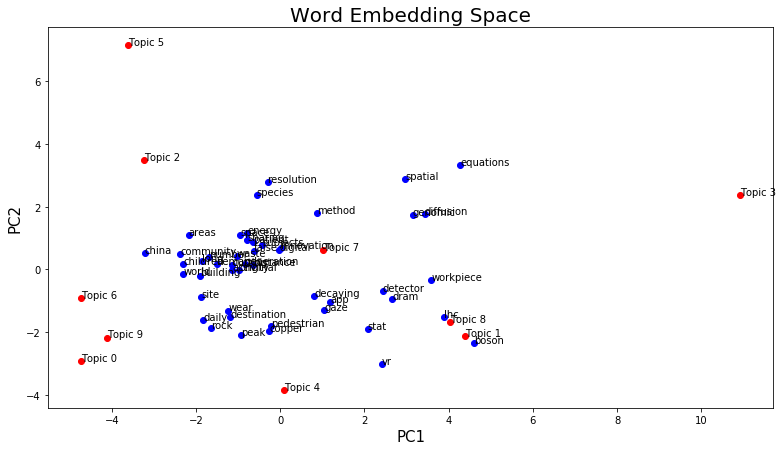

In [349]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(pca_topics[:,0], pca_topics[:,1],linewidths=1,color='red')
for i, _ in enumerate(topics):
    plt.annotate("Topic "+str(i),xy=(pca_topics[i,0],pca_topics[i,1]))
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
plt.scatter(pca_words[:,0], pca_words[:,1],linewidths=1,color='blue')
for i, word in enumerate(words):
    plt.annotate(word,xy=(pca_words[i,0],pca_words[i,1]))

---

In [ ]:
#!pip3.7 install umap-learn

In [237]:
# Plotting authors embeddings by department 
# We import sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

import umap.umap_ as umap


# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

In [92]:
# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [162]:
# get authors embeddings and labels (aka departments)
auths2dept = graph_data.drop_duplicates(["author","department"])[["author","department"]].dropna()
auths2dept["department"] = auths2dept.department.astype("category")
auths2dept["department_id"] = pd.factorize(auths2dept["department"])[0]
authors_list = auths2dept["author"].tolist()
authors_labels = auths2dept["department"].tolist()
authors_labels_ids = auths2dept["department_id"].tolist()
authors_list_embs = [authors_embeddings[list(authors2pubs_dict.keys()).index(name)] for name in authors_list]

In [175]:
num_dept = max(auths2dept["department_id"]) +1

In [163]:
authors_list_embs = np.asarray(authors_list_embs)
rows_to_keep = ~np.isnan(authors_list_embs).any(axis=1)
authors_list_embs = authors_list_embs[rows_to_keep]
authors_labels = np.asarray(authors_labels)[rows_to_keep]
authors_labels_ids = np.asarray(authors_labels_ids)[rows_to_keep]
authors_list = np.asarray(authors_list)[rows_to_keep]
authors_list_embs.shape

(460, 300)

In [205]:
auths_projected = TSNE(random_state=25111993).fit_transform(authors_list_embs)

In [206]:
pca = PCA(n_components=2)
auths_projected_pca = pca.fit_transform(authors_list_embs)

In [238]:
reducer = umap.UMAP()
auths_projected_umap = reducer.fit_transform(authors_list_embs)

In [224]:
def scatter(x, colors, labels_list, labels=False):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_dept))

    # We create a scatter plot.
    f = plt.figure(figsize=(15, 7))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    ax.axis('on')
    ax.axis('tight')

    txts = []
    if labels: 
    # We add the labels for each digit.
        for i in range(11):
            # Position of each label.
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(labels_list[i]), fontsize=50)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)

    return f, ax, sc, txts

{'PHYS', 'INFK', 'USYS', 'ARCH', 'GESS', 'BIOL', 'HEST', 'ERDW', 'BAUG', 'MATH', 'BSSE', 'ITET', 'MAVT', 'CHAB', 'MATL', 'MTEC'}


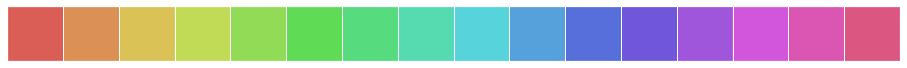

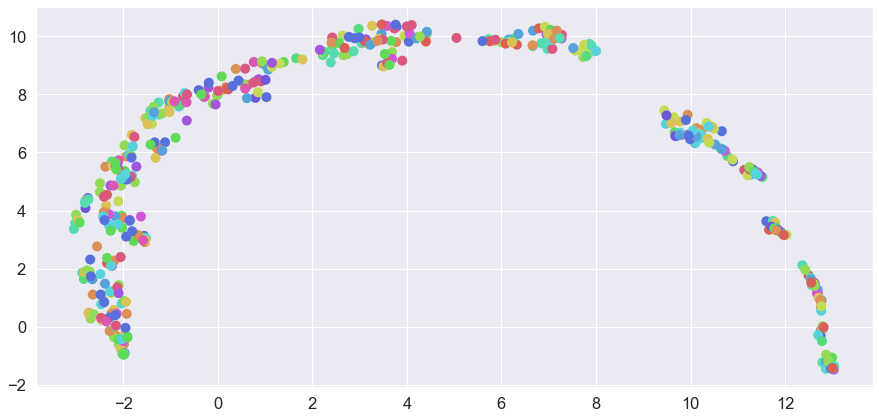

In [239]:
print(set(authors_labels))
sns.palplot(np.array(sns.color_palette("hls", num_dept)))
scatter(auths_projected_umap, authors_labels_ids, authors_labels)
pass
#plt.savefig('tsne-generated_18_clust_48_100.png', dpi=120)

## 5. Embedding topics - representation learning 

In [27]:
# Idea: a simple autoencoder to reconstruct topics embeddings
# The autoencoder takes as input the topic 2 word distribution and finds 
# a representation of the topic able to reconstruct it (+ idea: add noise in the input)
# We will enforce similarity with the topic words by applying a regulariser that measures 
# the non-similarity with the topic words 

In [28]:
import torch 
from torch import nn

In [29]:
class topicsLoss(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def topic_words_dissimilarity(self, hidden, topicwords_embs, topicwords_weights):
        """ 
        topicwords_embs: torch tensor of size BATCH x NUM_WORDS x EMB_DIM 
        topicwords_weights: torch tensor of size BATCH x NUM_WORDS 
        
        """
        # 1. normalise the weights 
        normalized_weights = weight_vec / np.sqrt(np.sum(weight_vec**2))
        # 2. compute hidden - embeddings distances
        distances = torch.cdist(topicwords_embs,hidden) # B x W
        # 3. dot product of weights and distances 
        total loss = 
        return total_loss 
    
    def forward(self, outputs, targets, hidden, topicswords_embs, topicswords_weights):
        loss = self.mse(outputs,targets) + self.topic_words_dissimilarity(hidden, topicswords_embs, topicswords_weights)
        return loss 
        
    
class topicsAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        """ 
        simply 4 shrinking linear layers with relu non linearities 
         - words2topic max -----> 150 
         - 150 -----> 300
         - 300 -----> 150
         - 150 -----> words2topic max
        """
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=150)
        self.encoder_output_layer = nn.Linear(in_features=150, out_features=300)
        self.decoder_hidden_layer = nn.Linear(in_features=300, out_features=150)
        self.decoder_output_layer = nn.Linear(in_features=150, out_features=kwargs["input_shape"])

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    

SyntaxError: invalid syntax (<ipython-input-29-6036a234a8c6>, line 17)

In [166]:
torch.cdist(c, a).size()

torch.Size([100, 100, 50])

In [163]:
torch.matmul(a.transpose(1,2),b.unsqueeze(2)).size()

torch.Size([100, 300, 1])

In [154]:
# input data 
# the input to the model is a set of words_indices vectors 
def get_input_data(topics2words, vocab, max_len):
    """ Returns a list of word indices for each of the topics 
    given as input. """
    words_idxs=[]
    topics_embs=[]
    topics_weights=[]
    for topic in topics2words: 
        twi = [0]*max_len
        topic_embeddings, topic_weights = get_list_embeddings_topic(topic, glove_vocab, glove_embedding, silence=True)
        # padding the vectors before adding them to the list 
        topics_embs += [F.pad(torch.tensor(topic_embeddings, requires_grad=False), [0,0,0,max_len-len(topic_embeddings)])] 
        topics_weights += [F.pad(torch.tensor(topic_weights,  requires_grad=False), 
                                 [0,max_len-len(topic_weights)])]
        for i,item in enumerate(topic): 
            word = item[0]
            try: # could fail if word not in the vocabulary
                twi[i] = list(vocab.values()).index(word)
            except Exception as e: pass
        words_idxs += [twi] 
    return words_idxs, topics_embs, topics_weights

In [130]:
MAX_INPUT_LEN = 50
input_data, topics_embs, topics_weights = get_input_data(topics2words, glove_vocab, MAX_INPUT_LEN)

In [141]:
EPOCHS = 20
NUM_TRAIN_BATCHES = 5 # 100 topics in 1 batch ---> 5 batches training 
train_batches = np.array_split(list(range(len(input_data))), NUM_TRAIN_BATCHES)
LR = 1e-3

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = topicsAE(input_shape=MAX_INPUT_LEN).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
criterion = topicsLoss()

In [ ]:
# training 
for epoch in range(epochs):
    loss = 0
    for batch in train_batch_data:
        # collecting input data
        model_input = torch.tensor(input_data[batch[0]:batch[-1]], dtype=torch.float)
        batch_topics_embs = torch.tensor(topics_embs[batch[0]:batch[-1]], requires_grad=False)
        batch_topics_weights = torch.tensor(topics_weights[batch[0]:batch[-1]],  requires_grad=False)
        
        optimizer.zero_grad()
        outputs = net(model_input)
        # get tensor embedding from the autoencoder 
        activation = net.encoder_hidden_layer(model_input)
        activation = torch.relu(activation)
        code = net.encoder_output_layer(activation)
        tensor_emb = torch.relu(code)
        # finally pass everything into the loss 
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))